    # SI Graph Plot
This notebook is designed to demonstrate (and to document) how to use the `shapiq.si_graph` plot. The SI-graph-plot visualizes all interactions of computed Shapley Interactions, including those of higher order, as a network. Players are represented as nodes, while explanations in the form of interactions are depicted as edges linking these nodes. Interactions between more than two features are visualized as a hyper-edge. Similar to the color scheme of shap, positive interactions are shown in red, negative interactions in blue. 
 The size of the node for a feature encodes the strength of its first-order interaction, with a larger node indicating a stronger main effect. The strength and direction of higher-order interactions are encoded through the color, transparency, and thickness of the edges; stronger interactions are shown as thicker and more opaque edges, while weaker interactions are represented by thinner and more transparent edges. The SI-graph plot is presented in Muschalik et al. (2024)[1]_.










In [26]:
import shapiq

{"shapiq version": shapiq.__version__}

{'shapiq version': '1.2.3.9000'}


## General Use
The easiest use is simply calling interaction_values.si_graph_plot() on the interaction values you want to visualize. 
But first, we import the needed modules and train a model we want to explain. We will be using a `RandomForestRegressor` for the bike_sharing data set and calculate the Shapley Values with the `TreeExplainer`.We now select an instance to explain and compute *k*-SII scores of order 4.


In [27]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# get the data
x_data, y_data = shapiq.datasets.load_california_housing(to_numpy=False)
feature_names = list(x_data.columns)  # get the feature names
n_features = len(feature_names)
print("Features in the dataset:", feature_names)

# train a model
x_data, y_data = x_data.values, y_data.values  # transform to numpy arrays
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
model = XGBRegressor(random_state=42, max_depth=4, n_estimators=50)
model.fit(x_train, y_train)

# evaluate the model
mse = mean_squared_error(y_test, model.predict(x_test))
r2 = r2_score(y_test, model.predict(x_test))
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# get interaction explanations
x_explain = x_test[2]  # get the first sample
explainer = shapiq.TabularExplainer(model, data=x_test, index="FSII", max_order=3, random_state=42)
explanation = explainer.explain(x_explain, budget=200)
print(explanation)

Features in the dataset: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Mean Squared Error: 0.24441967828624162
R2 Score: 0.8134783244431429
InteractionValues(
    index=FSII, max_order=3, min_order=0, estimated=True, estimation_budget=200,
    n_players=8, baseline_value=2.058321475982666,
    Top 10 interactions:
        (): 2.058321475982666
        (7,): 1.4029676257834733
        (5,): 0.4352382517680023
        (1,): 0.21230601018102915
        (1, 6, 7): 0.2047094819309096
        (1, 7): 0.1770493771092003
        (3,): 0.1725621981811153
        (1, 5): 0.15740142974032084
        (0,): -0.16957917640626122
        (6,): -0.4322103708427402
)


Creating an SI graph for a given set of Interaction Values is done by simply calling their `plot_si_graph` function or calling `si_graph_plot(interaction_values)`:  

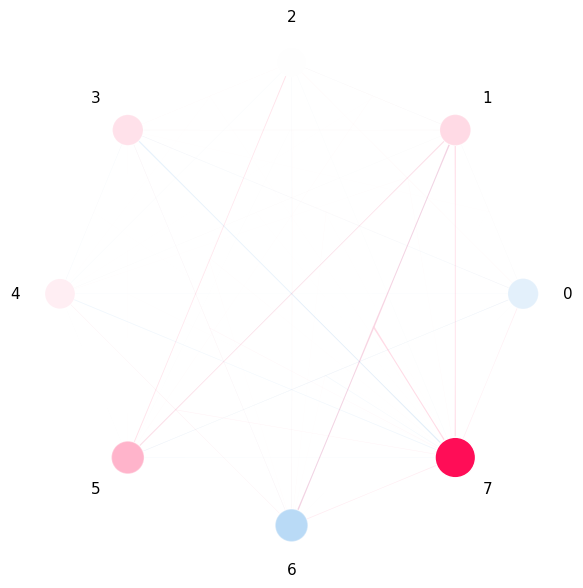

In [28]:
graph = explanation.plot_si_graph(show=False)

By default, nodes are drawn in a circular layout and the player's indices used as their names. Interactions of more than 2 players are shown using hyper-edges, see the interaction (0, 1, 9). The node size, color and opacity encode the importance of the main effect, see player 1 for an example of a high negative impact. 

## Scaling the graph
To get a more informative plot, let's add the feature names, and scale the explanations up a bit and make our player nodes smaller:


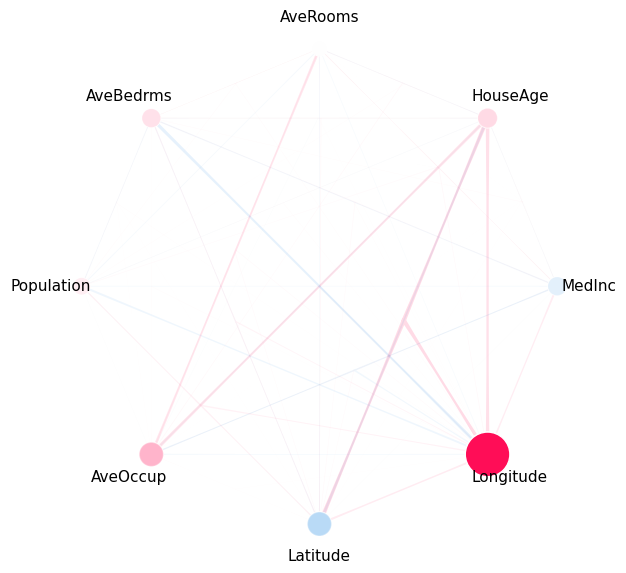

In [29]:
explanation.plot_si_graph(
    # the feature names can also be provided as a dict with the player indices
    feature_names=feature_names,
    size_factor=5.0,
    node_size_scaling=0.5,
)

Depending on the plot, it might be useful to change the scaling. SI plot provides several parameters to do so:
 ``size_factor`` allows to scale all explanations. For explanations with small general interaction values, a ``size_factor`` higher than one makes all interactions larger. A value between 0.0 and 1.0 scales them down. The default is 1.0. 
 If the nodes do not seem to fit, their values can be explicitly scaled with ``node_size_scaling``.

 

# Adjusting the positions
The positions of the nodes are determined automatically. The base case is a circular layout, we can change it to a spring layout by setting ``circular_layout = False``. It is also possible to set the positions manually, with a dict mapping the players to their respective positions. For features that are structured, we can give a graph that should be used as the underlying layout. Their positions are determined using a spring layout, which we can adjust with the parameters ``random_seed``, ``compactness`` and ``spring_k``. 

# Focusing on specific interactions
When plotting interaction values of higher orders, the number of edges can make it difficult to read. If we want to simplify our graph, we can filter and visualize only a subset of interactions that are most relevant. For example, we can focus on interactions above a certain threshold, select the 10 strongest interactions (by absolute value), or limit our view to only positive or negative interactions. Additionally, we can specify that we are only interested in interactions of a certain order (ur up to/higher than a certain order).


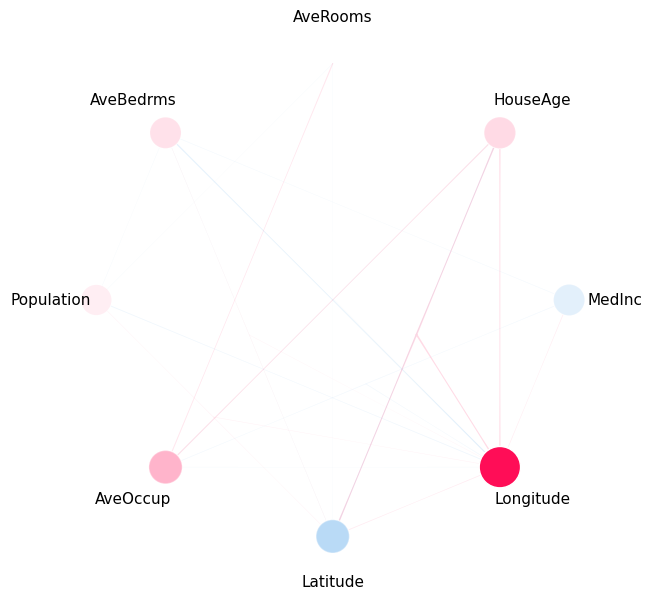

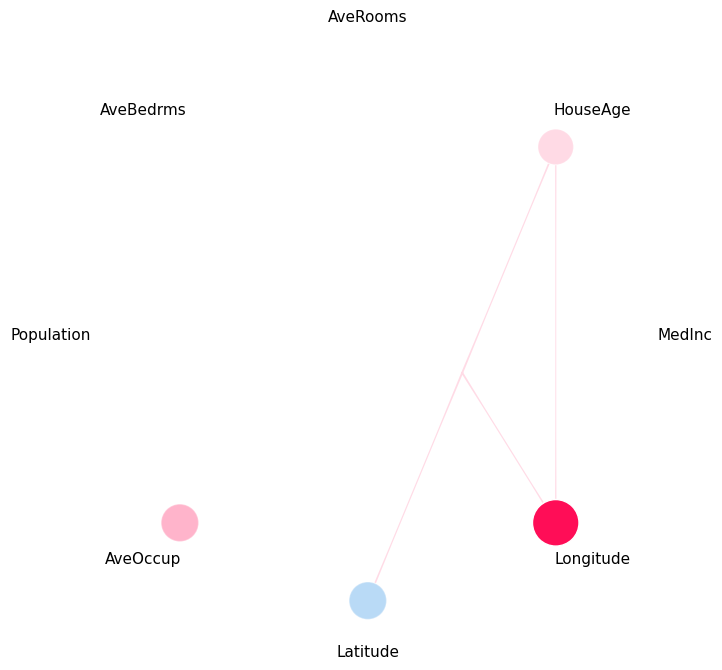

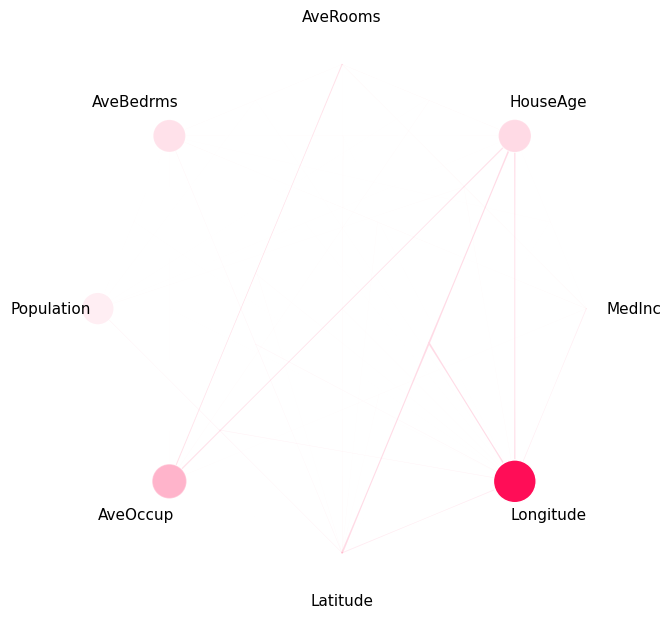

In [30]:
# only interactions >= threshold are plotted
explanation.plot_si_graph(
    feature_names=feature_names,
    draw_threshold=0.05,
)
# the largest n interactions (absolute value). If the empty set is not assigned zero, it could count as one without showing up in the plot.
explanation.plot_si_graph(
    feature_names=feature_names,
    n_interactions=7,
)
explanation.plot_si_graph(
    feature_names=feature_names,
    interaction_direction="positive",  # or 'negative'
)

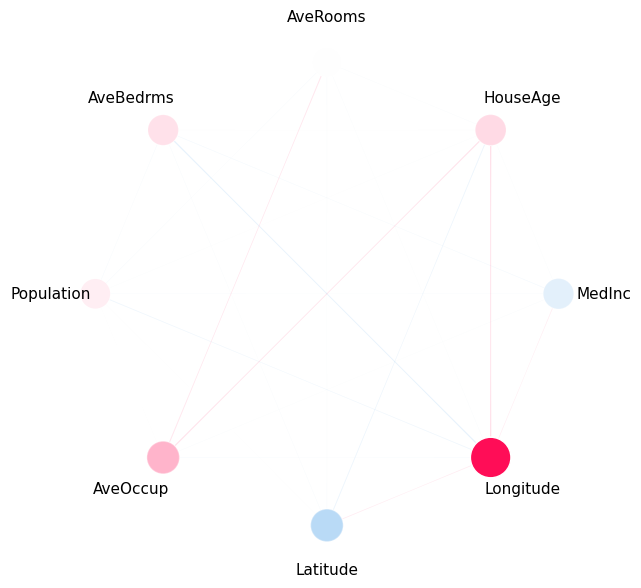

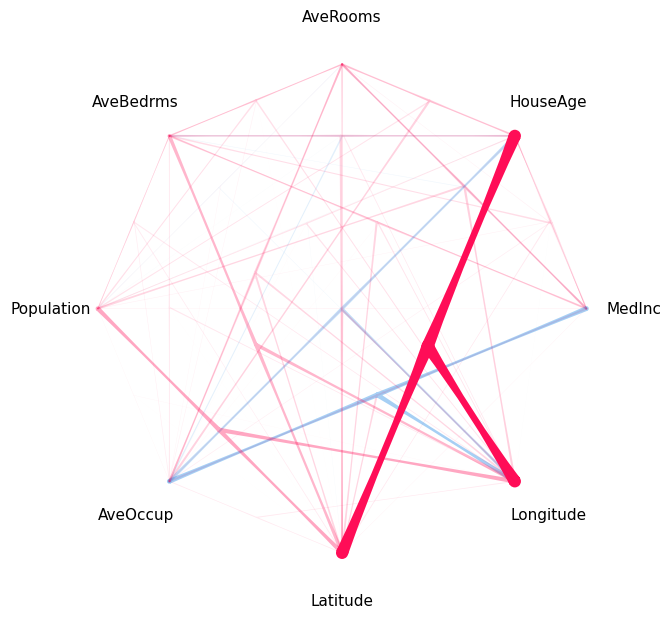

In [31]:
# if we want to have the interactions up to (inclusive) a certain order
explanation.plot_si_graph(
    feature_names=feature_names,
    min_max_order=(1, 2),
)
# or only those bigger/equal to a specific order
explanation.plot_si_graph(
    feature_names=feature_names,
    min_max_order=(3, -1),
)

It's possible to combine these parameters, but keep in mind that the top-n interactions are determined first, any additional filters are applied after. The scaling will fit the highest and lowest shown interaction, to keep scaling consistent between several graphs, you can fix the original highest/lowest interaction as scaling points with ``min_max_interaction``. 

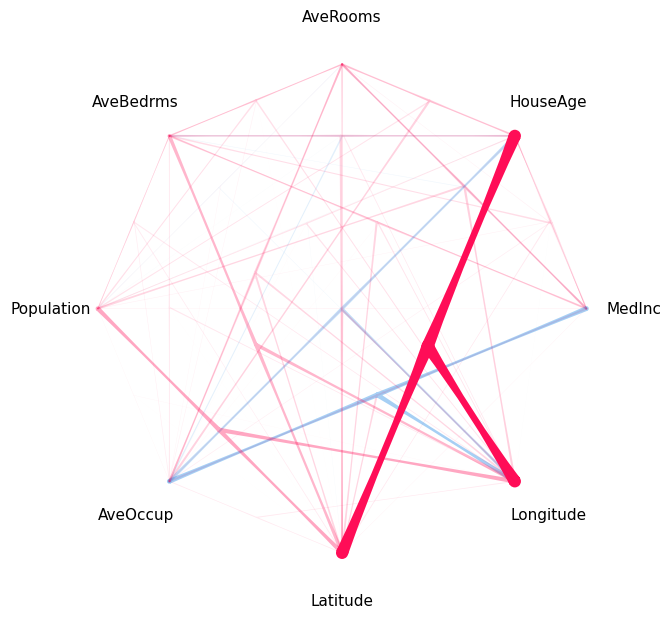

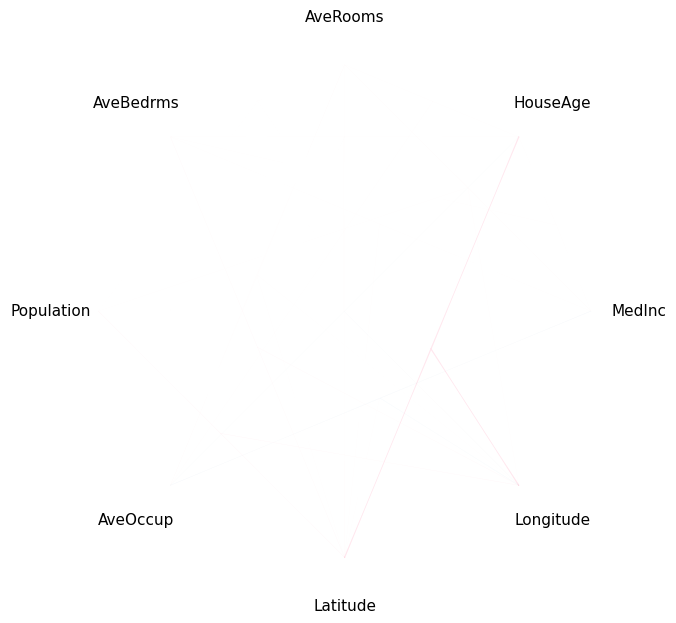

In [32]:
# plot only one specific order. The largest interactions are not of that order, so scaling will adjust itself
explanation.plot_si_graph(
    feature_names=feature_names,
    min_max_order=(3, 3),
)
# unless we specify the scaling interactions, which will lead most interactions to almost vanish.
min_interaction, max_interaction = min(abs(explanation.values)), max(abs(explanation.values))
explanation.plot_si_graph(
    feature_names=feature_names,
    min_max_order=(3, 3),
    min_max_interactions=(min_interaction, max_interaction),
)

## Feature Images
If we have features that can be better expressed via images (patches of an image classifier for example), we can replace the text labels with the corresponding image patches. Let's load an example image classifier and visualize the explanations using these patches

In [33]:
from PIL import Image

from shapiq import ExactComputer
from shapiq.games.benchmark import ImageClassifierLocalXAI

# get an image
image_path = "../images/original_image.jpg"
image = Image.open(image_path)
# create the game
game = ImageClassifierLocalXAI(
    model_name="vit_9_patches",
    x_explain_path=image_path,
    verbose=True,
)
# calculate the shapley values
exact = ExactComputer(n_players=game.n_players, game=game)
explanation = exact(index="k-SII", order=2)

/home/louis/IdeaProjects/shapiq/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Original class: golden retriever (0.2026)


Evaluating game: 100%|██████████| 512/512 [04:28<00:00,  1.91 coalition/s]


In [34]:
# create the image patches
width, height = image.size
patch_width = width // 3
patch_height = height // 3
patches = []
for row in range(3):
    for col in range(3):
        left = col * patch_width
        upper = row * patch_height
        right = left + patch_width
        lower = upper + patch_height

        patch = image.crop((left, upper, right, lower))  # Patch ausschneiden
        patches.append(patch)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


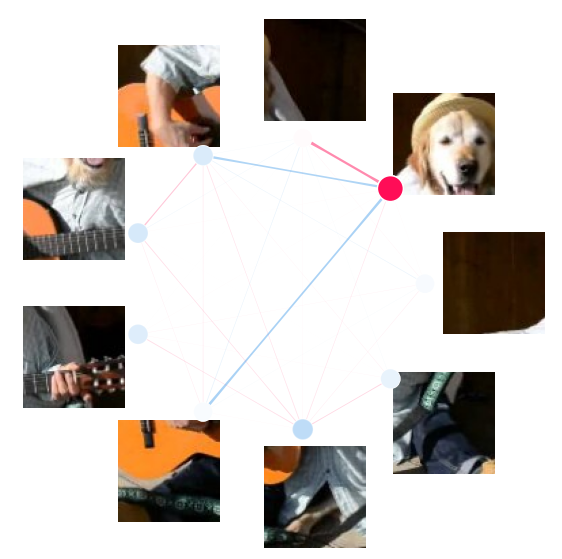

In [35]:
explanation.plot_si_graph(
    feature_image_patches=patches,
    feature_image_patches_size=0.3,
)

## Inserting a known graph structure
Some datasets have an inherent graph structure. To integrate these relations, we can provide a graph either as an edge list or as a nx.Graph instance. Instead of the explanation nodes, we can adjust the layout using ``plot_original_nodes``, which displays nodes as white circles with their labels inside. Large primary effects will show as a halo around them (again scalable with ``node_size_scaling``. It is also possible to show the graph without added explanations (``plot_explanation=False``).
